# Simple cuProj WGS84 to UTM Projection Benchmark

This notebook is a simple benchmark of the cuProj library. It compares the performance of the cuProj library to the performance of the [PyProj]https://pyproj4.github.io/pyproj/stable/index.html) library. The benchmark is performed on a single GPU and a single CPU, respectively.

## Imports and setup

In [8]:
import cupy as cp
import numpy as np

from cuda import cudart

from pyproj import Transformer
from cuproj import Transformer as cuTransformer

import timeit

import matplotlib.pyplot as plt


The benchmark is performed on a 2D grid of (latitude, longitude) points in the WGS84 (EPSG 4326) coordinate reference system (CRS), transforming them to UTM Zone 10N (EPSG 32610) . The grid is defined around San Francisco, California, USA.

In [9]:

# San Francisco bounding box
min_corner = (37.7081, -122.5149)
max_corner = (37.8324, -122.3573)
crs_from = "EPSG:4326"
crs_to = "EPSG:32610"

The following functions generate a grid and transform all the points on the grid from WGS84 to UTM.
There are two versions of the cuProj benchmark: one uses a Cupy ndarray stored in device memory and the other a Numpy ndarray stored in host memory. The latter includes the cost to copy the data from host to device memory, while the former times only the GPU computation.

In [10]:
def run_pyproj(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = Transformer.from_crs(crs_from, crs_to)

    x, y = np.meshgrid(np.linspace(min_corner[0], max_corner[0], grid_side),
                       np.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    t = timeit.Timer(lambda: transformer.transform(*grid))
    return t.autorange()

def cu_run_and_sync(transformer, grid):
  transformer.transform(*grid)
  cudart.cudaDeviceSynchronize()

def run_cuproj(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = cuTransformer.from_crs(crs_from, crs_to)

    x, y = cp.meshgrid(cp.linspace(min_corner[0], max_corner[0], grid_side),
                       cp.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    t = timeit.Timer(lambda: cu_run_and_sync(transformer, grid))
    return t.autorange()

def run_cuproj_host_data(num_points):
    grid_side = int(np.sqrt(num_points))
    transformer = cuTransformer.from_crs(crs_from, crs_to)

    x, y = np.meshgrid(np.linspace(min_corner[0], max_corner[0], grid_side),
                       np.linspace(min_corner[1], max_corner[1], grid_side))

    grid = [x.reshape(-1), y.reshape(-1)]

    t = timeit.Timer(lambda: cu_run_and_sync(transformer, grid))
    return t.autorange()

## Run Benchmarks

Run each benchmark and compute the throughput in points per second.

In [11]:
num_points = np.geomspace(100, 1e8, 7).astype(int)

throughput_pyproj = []
throughput_cuproj = []
throughput_cuproj_host_data = []

# pyproj
for n in num_points:
    iters, time = run_pyproj(n)
    throughput_pyproj.append(n / (time / iters))
    
# cuproj data on device
for n in num_points:
    iters, time = run_cuproj(n)
    throughput_cuproj.append(n / (time / iters))

# cuproj including host to device copy
for n in num_points:
    iters, time = run_cuproj_host_data(n)
    throughput_cuproj_host_data.append(n / (time / iters))

## Results

Plot the results using matplotlib.

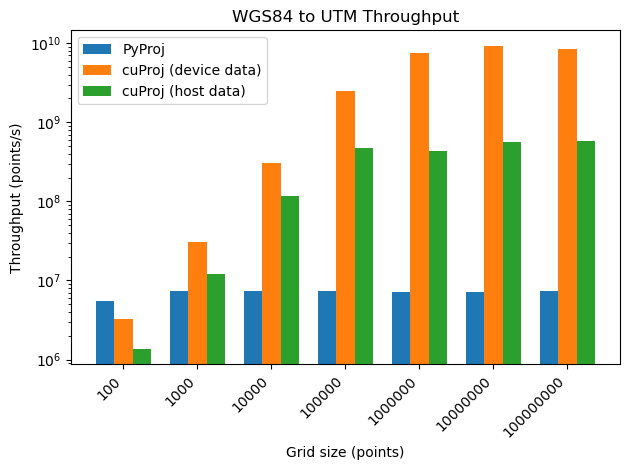

In [12]:
mean_throughputs = {'PyProj': throughput_pyproj, 
          'cuProj (device data)': throughput_cuproj,
          'cuProj (host data)': throughput_cuproj_host_data}

x = np.arange(len(num_points))
width = 0.25

fig, ax = plt.subplots()

ax.set_yscale('log')
ax.set_ylabel('Throughput (points/s)')
ax.set_xlabel('Grid size (points)')
ax.set_title('WGS84 to UTM Throughput')
ax.set_xticks(x)
ax.set_xticklabels(num_points)
ax.set_xticklabels(num_points, rotation=45, ha='right')

for i, label in enumerate(mean_throughputs.keys()):
  rects = ax.bar(x + (i - 1) * width, mean_throughputs[label], width, label=label)

ax.legend()
fig.tight_layout()
plt.show()
